# Analyse de sensibilité globale avec les indices de Sobol' - application au cas de la déviation verticale de la poutre


# Model definition

In [1]:
import openturns as ot
import numpy as np

In [2]:
ot.Log.Show(ot.Log.NONE)

In [3]:
ot.RandomGenerator.SetSeed(1976)

In [4]:
dist_E = ot.Beta(0.9, 2.2, 2.8e7, 4.8e7)
dist_E.setDescription(["E"])
F_para = ot.LogNormalMuSigma(3.0e4, 9.0e3, 15.0e3)  # in N
dist_F = ot.ParametrizedDistribution(F_para)
dist_F.setDescription(["F"])
dist_L = ot.Uniform(250.0, 260.0)  # in cm
dist_L.setDescription(["L"])
dist_I = ot.Beta(2.5, 1.5, 310.0, 450.0)  # in cm^4
dist_I.setDescription(["I"])

X = ot.ComposedDistribution([dist_E, dist_F, dist_L, dist_I])

In [5]:
g = ot.SymbolicFunction(["E", "F", "L", "I"], ["F* L^3 /  (3 * E * I)"])
g.setOutputDescription(["Y (cm)"])

Pour pouvoir exploiter au mieux les simulations, nous équipons la fonction d'un méchanisme d'historique.

In [6]:
g = ot.MemoizeFunction(g)

Enfin, nous définissons le vecteur aléatoire de sortie.

In [7]:
XRV = ot.RandomVector(X)
Y = ot.CompositeRandomVector(g, XRV)
Y.setDescription(["Y (cm)"])

## Estimer les indices de Sobol' avec un budget fixé

Le composant d'estimation des indices de Sobol' est équipé d'un système qui permet d'évaluer la fonction en dehors d'OpenTURNS. Pour l'utiliser, on créée un type de plans d'expériences spécial en utilisant la classe `SobolIndicesExperiment`. La méthode `generate` permet de créer le plan d'expériences associé à une taille fixée par l'utilisateur. 

In [8]:
size = 500
computeSecondOrder = False
sie = ot.SobolIndicesExperiment(X, size, computeSecondOrder)
inputDesign = sie.generate()

La taille `size` est la taille du plan Monte-Carlo de base, utilisé pour obtenir un estimateur. Or 10 estimations sont requises dans ce cas particulier :
- une estimation de la moyenne de Y c'est à dire $E(Y)$ et une estimation de la variance de Y c'est à dire $V(Y)$
- une estimation des quatre indices du premier ordre $S_E$, $S_F$, $S_L$, $S_I$,
- une estimation des quatre indices totaux $T_E$, $T_F$, $T_L$, $T_I$.

Pour estimer ces quantités, la méthode pick-freeze requiert 
* un plan d'expériences de type "A",
* un plan d'expériences de type "B",
* des plans d'expériences de type "E" dont le nombre est égal à la dimension du vecteur d'entrée.

Il y a donc ici 4 plans d'expériences de type "E".

C'est pour cette raison que la taille du plan d'expérience permettant d'estimer toutes les quantités requises est égal à (1+1+4) * 500 = 3000.

In [9]:
inputDesign.getSize()

3000

In [10]:
outputDesign = g(inputDesign)

La librairie dispose de quatre estimateurs des indices de Sobol'. Ici, nous proposons d'utiliser l'estimateur de Saltelli. 

In [11]:
sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)

On souhaite obtenir la distribution asymptotique.

In [12]:
sensitivityAnalysis.setUseAsymptoticDistribution(True)

Les méthodes `getFirstOrderIndices` et `getTotalOrderIndices` permettent de récupérer les indices du premier ordre et totaux.

In [13]:
firstOrderIndices = sensitivityAnalysis.getFirstOrderIndices()
firstOrderIndices

class=Point name=Unnamed dimension=4 values=[0.083941,0.840896,-0.0533601,0.00705359]

In [14]:
totalOrderIndices = sensitivityAnalysis.getTotalOrderIndices()
totalOrderIndices

class=Point name=Unnamed dimension=4 values=[0.189603,0.809747,0.00271188,0.0870348]

La méthode `draw` propose une méthode de dessin des indices de Sobol' qui permet d'observer à la fois les indices du premier ordre, les indices totaux et les intervalles de confiance.

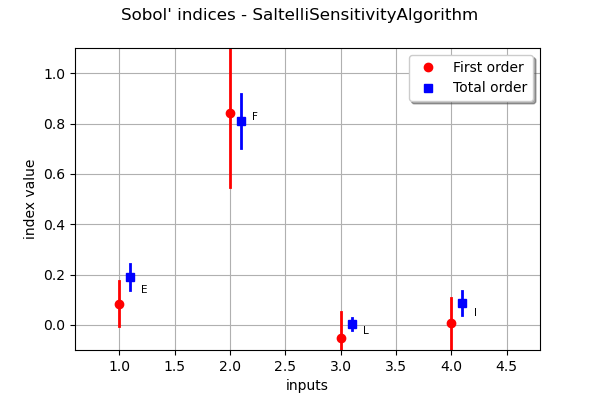

In [15]:
sensitivityAnalysis.draw()

Considérons en particulier la variable F. On observe que l'estimation de l'indice de sensibilité du premier ordre est légèrement supérieur à l'estimation de l'indice total. On sait que les valeurs exactes sont toujours de telle sorte que l'indice total est supérieur ou égal à l'indice du premier ordre. C'est donc à cause de l'erreur d'estimation que l'on obtient un ordre inverse. C'est la marque que 
- la taille de l'échantillon n'est pas suffisamment grande,
- ou l'indice du premier ordre est égal à l'indice total car il n'y a pas d'interaction.

Dans ce cas particulier, on observe que l'intervalle de confiance à 95% indique que l'estimation de l'indice du premier ordre de F est particulièrement large, approximativement entre 0.6 et 1.1. Dans ce cas particulier, il est pertinent d'augmenter la taille de l'échantillon.

La méthode `DrawSobolIndices` permet de réaliser un graphique similaire lorsque les indices sont déjà disponibles.

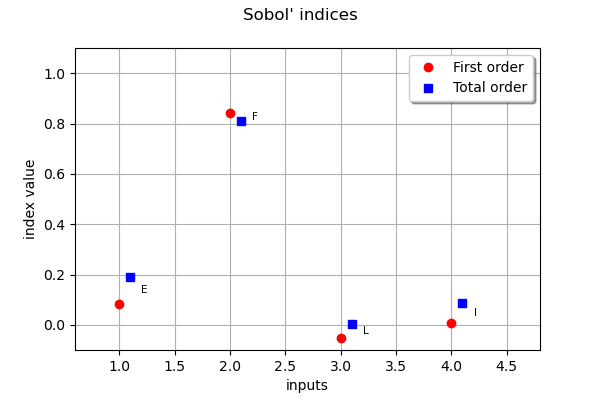

In [16]:
inputDescription = X.getDescription()
ot.SaltelliSensitivityAlgorithm.DrawSobolIndices(
    inputDescription, firstOrderIndices, totalOrderIndices
)

La méthode `getFirstOrderIndicesDistribution` retourne la distribution des indices de Sobol'. Elle peut être de deux types différents.
- Par défaut, la distribution des indices de Sobol' est estimée par bootstrap. Dans ce cas, la valeur de retour de `getFirstOrderIndicesDistribution` est de type `KernelMixture`, c'est à dire fondée sur une méthode d'estimation à noyau.
- Si on utilise la méthode `setUseAsymptoticDistribution`, alors on peut obtenir la distribution asymptotique fondée sur la delta méthode. Dans ce cas, la valeur de retour de `getFirstOrderIndicesDistribution` est de type `Normal`.

In [17]:
fo_dist = sensitivityAnalysis.getFirstOrderIndicesDistribution()
fo_dist

class=Normal name=Normal dimension=4 mean=class=Point name=Unnamed dimension=4 values=[0.083941,0.840896,-0.0533601,0.00705359] sigma=class=Point name=Unnamed dimension=4 values=[0.0461918,0.149686,0.0540539,0.0517245] correlationMatrix=class=CorrelationMatrix dimension=4 implementation=class=MatrixImplementation name=Unnamed rows=4 columns=4 values=[1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1]

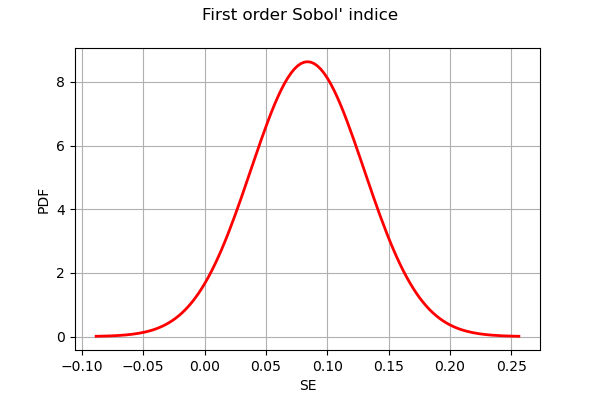

In [18]:
fo_SX0 = fo_dist.getMarginal(0)
graph = fo_SX0.drawPDF()
graph.setXTitle("S" + inputDescription[0])
graph.setTitle("First order Sobol' indice")
graph.setLegends([""])
graph

## Estimer les indices de Sobol' avec un algorithme incrémental

La classe `SobolSimulationAlgorithm` permet d'estimer les indices de Sobol' à l'aide d'un algorithme incrémental. L'objectif principal de cette classe est de pouvoir configurer la précision d'estimation de l'indice de Sobol' à l'aide d'un intervalle de confiance dont le niveau de confiance `alpha` et la largeur `epsilon` sont fixés par l'utilisateur. Ainsi, les simulations sont réalisées par bloc, ce qui garantit à la fois une performance maximale sur les supercalculateurs et un nombre minimal de blocs évalués. 

In [19]:
alpha = 0.05  # i.e. 95% confidence interval
epsilon = 0.2  # Confidence interval length
blocksize = 50  # size of Sobol experiment at each iteration
batchsize = 16  # number of points evaluated simultaneously

In [20]:
estimator = ot.SaltelliSensitivityAlgorithm()
estimator.setUseAsymptoticDistribution(True)
algo = ot.SobolSimulationAlgorithm(X, g, estimator)
algo.setMaximumOuterSampling(100)  # number of iterations
algo.setBlockSize(blocksize)
algo.setBatchSize(batchsize)
algo.setIndexQuantileLevel(alpha)  # alpha
algo.setIndexQuantileEpsilon(epsilon)  # epsilon
algo.run()

In [21]:
result = algo.getResult()
fo = result.getFirstOrderIndicesEstimate()
to = result.getTotalOrderIndicesEstimate()
print("First order = %s" % (str(fo)))
print("Total order = %s" % (str(to)))

First order = [0.150187,0.899086,0.00834214,0.0637259]
Total order = [0.140138,0.819791,0.0106326,0.0582963]


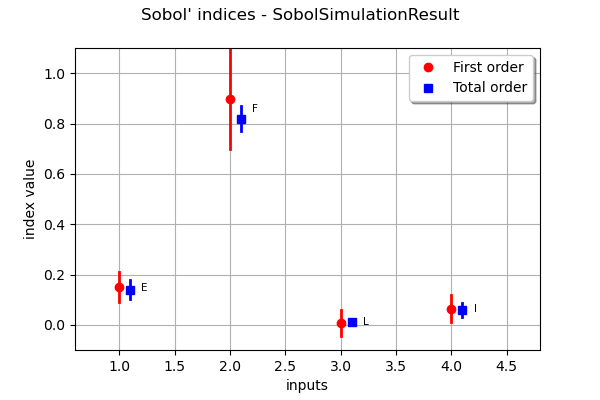

In [22]:
result.draw()

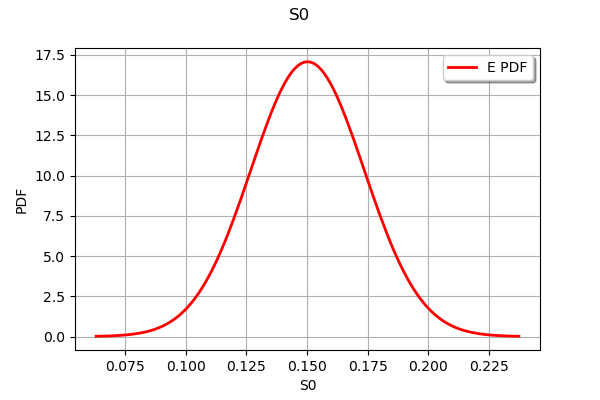

In [23]:
dist_fo = result.getFirstOrderIndicesDistribution()
dist_fo_i = dist_fo.getMarginal(0)
graph = dist_fo_i.drawPDF()
graph.setTitle("S0")
graph.setXTitle("S0")
graph

## Synthèse

La table suivant résume les résultats.

| Variable | Premier ordre, I.C. à 95 % | Total, I.C. à 95 % |
|--|--|--|
| $E$ | [0.11,0.19] | [0.12,0.17] |
| $F$ | [0.77,1.03] | [0.79,0.85] |
| $L$ | [-0.03,0.04] | [0.00,0.02] |
| $I$ | [0.03,0.10] | [0.04,0.08] |

Voici les conclusions que l'on peut tirer.

- La variable $F$ est la variable qui contribue le plus à la variabilité de la sortie, à hauteur de 70 à 80%.
- La variable $E$ est la seconde variable qui contribue le plus à la variabilité de la sortie, à hauteur de 10 à 20%.
- Les deux autres variables $L$ et $I$ contribuent à moins de 10 % de la variabilité de la sortie : elles pourrait être remplacées par des constantes (surtout la variable $L$), sans que la variabilité de la sortie $Y$ ne soit beaucoup modifiée.
- Sur la base des calculs, on peut indiquer que les interactions, si elles existent, ne contribuent pas beaucoup à la variabilité de la sortie. 

## Exercice 1 : fonction produit

On considère la fonction :

$$
g(X_1,X_2)=X_1 X_2
$$

pour tout $X_1,X_2\in\mathbb{R}$. 

On suppose que les variables sont indépendantes et suivent les lois suivantes.

| Variable | Distribution |
|--|--|
| $X_1$ | Normal($\mu=0$, $\sigma=10$) |
| $X_2$ | Uniforme($a=-1$, $b=1$) |

La cellule suivante définit le modèle.

In [24]:
g = ot.SymbolicFunction(["X1", "X2"], ["X1 * X2"])
X1 = ot.Normal(0.0, 10.0)
X2 = ot.Uniform(-1.0, 1.0)
X = ot.ComposedDistribution([X1, X2])
inputDescription = ["X1", "X2"]
X.setDescription(inputDescription)

*Questions*

- Estimer les indices SRC. Pour cela, utiliser la classe `CorrelationAnalysis_SRC`. 
- Pour valider vos résultats, utiliser la fonction `CorrelationAnalysis_PearsonCorrelation`. Par exemple, pour estimer l'indice SRC de la i-ème  variable, on utilise l'instruction suivante
```
ot.CorrelationAnalysis_PearsonCorrelation(sampleY,sampleX[:,i])[0]
```
Comparer vos résultats : qu'observez-vous ?

- Estimer les indices de Sobol' avec la classe `SaltelliSensitivityAlgorithm`. Qu'observez-vous ? Comment expliquer ce résultat ?

## Solution de l'exercice 1 : fonction produit

In [25]:
n = 10000
sampleX = X.getSample(n)
sampleY = g(sampleX)

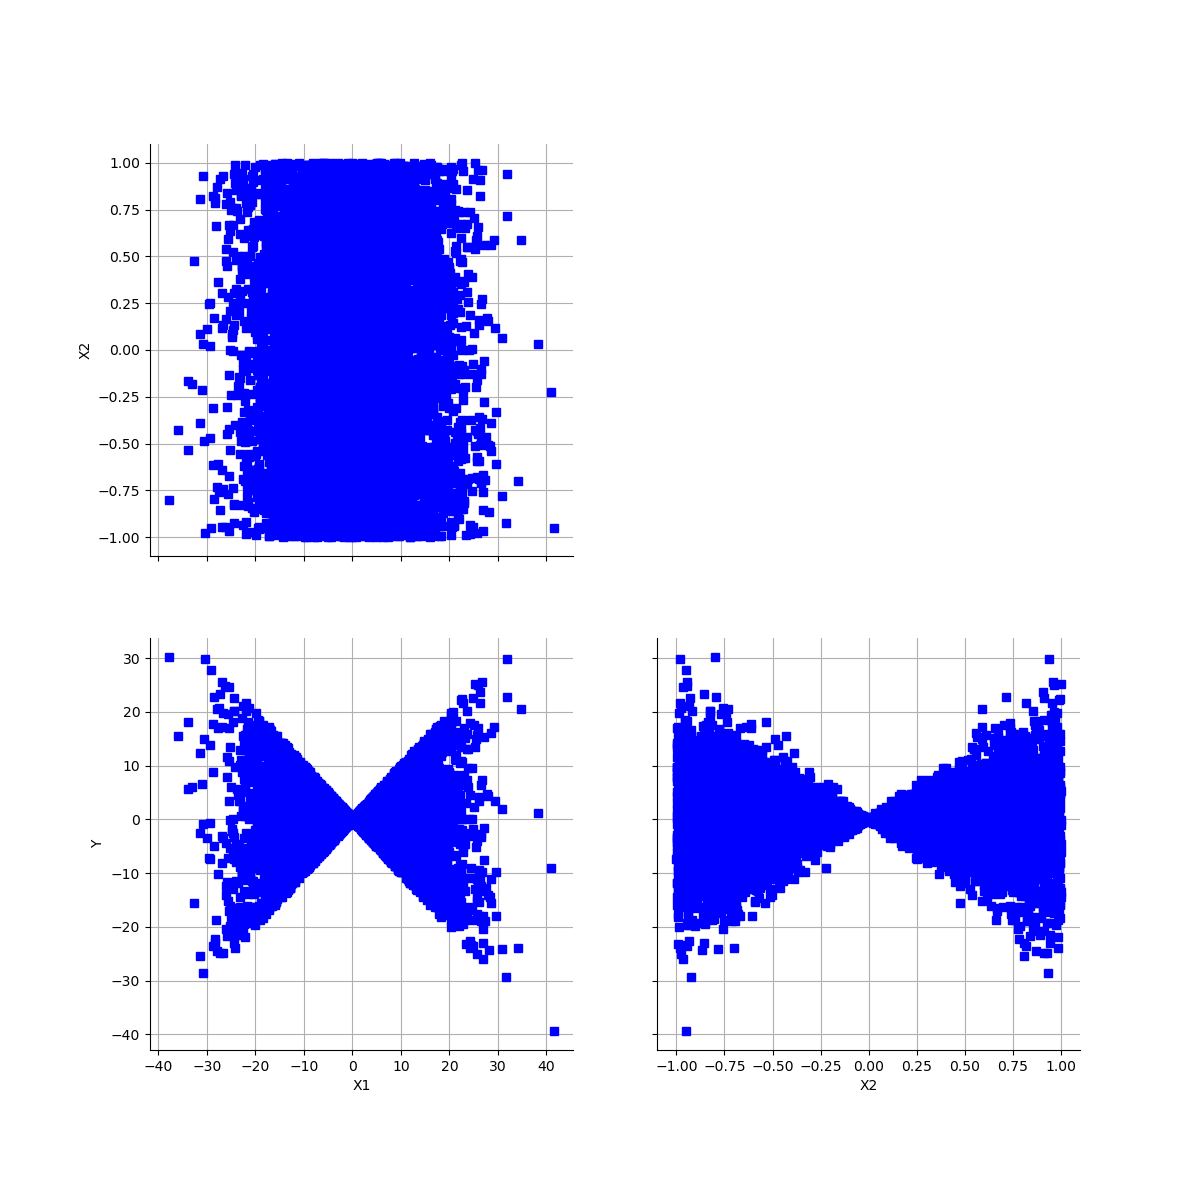

In [26]:
data = ot.Sample(n, 3)
data[:, 0:2] = sampleX
data[:, 2] = sampleY
data.setDescription(["X1", "X2", "Y"])
ot.VisualTest_DrawPairs(data)

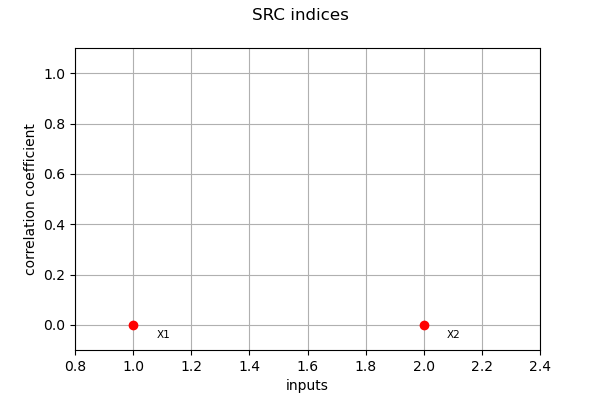

In [27]:
SRCindices = ot.CorrelationAnalysis_SRC(sampleX, sampleY)
input_names = g.getInputDescription()
title = "SRC indices"
ot.SobolIndicesAlgorithm.DrawCorrelationCoefficients(SRCindices, input_names, title)

Pour valider notre résultat, nous utilisons la fonction `CorrelationAnalysis_PearsonCorrelation` qui calcule le coefficient de corrélation linéaire. 

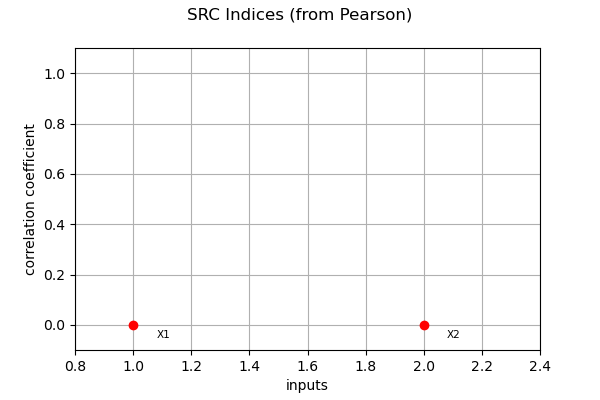

In [28]:
SRCindices = ot.Point(2)
SRCindices[0] = (
    ot.CorrelationAnalysis_PearsonCorrelation(sampleY, sampleX[:, 0])[0] ** 2
)
SRCindices[1] = (
    ot.CorrelationAnalysis_PearsonCorrelation(sampleY, sampleX[:, 1])[0] ** 2
)
title = "SRC Indices (from Pearson)"
ot.SobolIndicesAlgorithm.DrawCorrelationCoefficients(SRCindices, input_names, title)

On observe que les résultats sont très différents. Il s'avère que ce modèle est associé à une somme des coefficients SRC qui est égale à 5% seulement. Cela implique que 95% de la variance de la sortie n'est pas expliquée par le modèle linéaire, qui est donc ici une très mauvaise approximation de la fonction $g$. Les indices SRC ne peuvent donc pas être utilisés dans ce cas.

Pour obtenir des résultats valables, on utilise alors les indices de Sobol'.

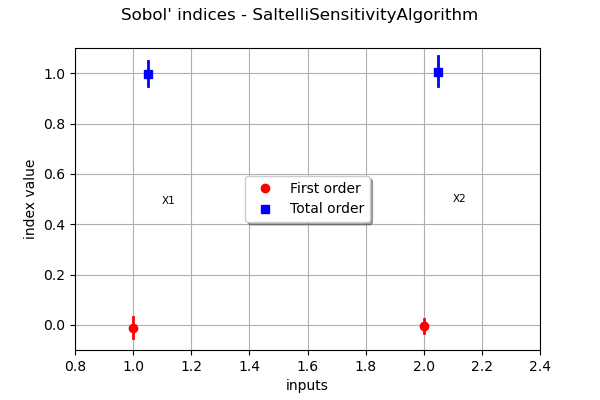

In [29]:
size = 10000
sie = ot.SobolIndicesExperiment(X, size, True)
inputDesign = sie.generate()
outputDesign = g(inputDesign)
sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)
graph = sensitivityAnalysis.draw()
graph.setLegendPosition("center")
graph

On observe que les indices du premier ordre sont tous les deux proches de 0 et que les indices totaux sont tous les deux proches de 1. Pour valider ce résultat, nous réalisons un calcul théorique.

Pour $i=1,2$, notons $\mu_i = E(X_i)$ l'espérance et $\sigma_i^2=V(X_i)$ la variance. 

Notons $f_i$ la densité de probabilité de la variable $X_i$ pour $i=1,2$ et $f_{1,2}$ la densité de probabilité 
du vecteur aléatoire $(X_1,X_2)$. Puisque les variable $X_1$ et $X_2$ sont indépendantes, la densité de probabilité du vecteur aléatoire $(X_1,X_2)$ est le produit des lois marginales :

$$
f_{1,2}(x_1,x_2) = f_1(x_1)f_2(x_2)
$$

pour tout $x_1,x_2\in\mathbb{R}$.

On en déduit que l'espérance de $Y$ est égale au produit des espérances de $X_1$ et $X_2$. 
En effet, 

\begin{align*}
E(Y) 
&= E(X_1 X_2) \\
&= \int_{\mathbb{R}^2} x_1 x_2 f_{1,2}(x_1,x_2) dx_1 dx_2 \\
&= \int_{\mathbb{R}^2} x_1 x_2 f_1(x_1)f_2(x_2) dx_1 dx_2 \\
&= \left(\int_{\mathbb{R}} x_1 f_1(x_1) dx_1\right) \left(\int_{\mathbb{R}} f_2(x_2) dx_2 \right) \\
&= E(X_1)E(X_2) \\
&= \mu_1 \mu_2
\end{align*}

La variance de $Y$ est :

\begin{align*}
V(Y) 
&= E(Y^2) - E(Y)^2 \\
&= E[(X_1X_2)^2] - E(Y)^2 \\
&= E(X_1^2)E(X_2^2) - E(Y)^2 \textrm{ (par indépendance)}.
\end{align*}

Or, pour $i=1,2$, on a :

$$
E(X_i^2) = V(X_i) + E(X_i)^2 = \sigma_i^2 + \mu_i^2.
$$

Par conséquent, 

\begin{align*}
V(Y) 
&= (\sigma_1^2 + \mu_1^2)(\sigma_2^2 + \mu_2^2) - \mu_1^2 \mu_2^2 \\
&= \sigma_1^2 \sigma_2^2 + \sigma_1^2 \mu_2^2 + \sigma_2^2 \mu_1^2.
\end{align*}

L'indice de Sobol' du premier ordre de $X_1$ est :

\begin{align*}
S_1
&= \frac{V[E(Y|X_1)]}{V(Y)} \\
&= \frac{V[X_1E(X_2)]}{V(Y)} \\
&= \frac{V(X_1 \mu_2)}{V(Y)} \\
&= \frac{\mu_2^2 V(X_1)}{V(Y)} \\
&= \frac{\mu_2^2 \sigma_1^2}{V(Y)}.
\end{align*}

De même, 

\begin{align*}
S_2
&= \frac{\mu_1^2 \sigma_2^2}{V(Y)}.
\end{align*}

Etant donnée la variance totale $V(Y)$, l'indice du second ordre $S_{1,2}$ est égal à 

\begin{align*}
S_{1,2} 
&= 1 - S_1 - S_2 \\
&= \frac{V(Y) - S_1 V(Y) - S_2 V(Y)}{V(Y)} \\
&= \frac{\sigma_1^2 \sigma_2^2 + \sigma_1^2 \mu_2^2 + \sigma_2^2 \mu_1^2 - \mu_2^2 \sigma_1^2 - \mu_1^2 \sigma_2^2}{V(Y)} \\
&= \frac{\sigma_1^2 \sigma_2^2}{V(Y)}.
\end{align*}

L'indice SRC de $X_1$ est égal à la corrélation entre $Y$ et $X_1$. 
Par définition, la covariance est égale à :

\begin{align*}
Cov(Y,X_1)
&= E[(Y-E(Y))(X_1-E(X_1))] \\
&= E(YX_1) - E(Y)E(X_1) \\
&= E(X_1^2 X_2) - \mu_1 \mu_2 \mu_1 \\
&= E(X_1^2) E(X_2) - \mu_1^2 \mu_2 \textrm{ (par indépendance)} \\
&= (\sigma_1^2 + \mu_1^2) \mu_2 - \mu_1^2 \mu_2 \\
&= \sigma_1^2 \mu_2.
\end{align*}

De même, 

\begin{align*}
Cov(Y,X_2)
&= E[(Y-E(Y))(X_2-E(X_2))] \\
&= E(YX_2) - E(Y)E(X_2) \\
&= E(X_1 X_2^2) - \mu_1 \mu_2 \mu_2 \\
&= E(X_1) E(X_2^2) - \mu_1 \mu_2^2 \textrm{ (par indépendance)} \\
&= \mu_1 (\sigma_2^2 + \mu_2^2) - \mu_1 \mu_2^2 \\
&= \mu_1 \sigma_2^2 .
\end{align*}

Par conséquent,

\begin{align*}
SRC_1
&= Corr(Y,X_1) \\
&= \frac{Cov(Y,X_1)}{\sqrt{V(Y)}\sqrt{V(X_1)}} \\
&= \frac{\sigma_1^2 \mu_2}{\sqrt{V(Y)}\sigma_1} \\
&= \frac{\sigma_1 \mu_2}{\sqrt{V(Y)}}
\end{align*}

et :

\begin{align*}
SRC_2
&= Corr(Y,X_2) \\
&= \frac{Cov(Y,X_2)}{\sqrt{V(Y)}\sqrt{V(X_2)}} \\
&= \frac{\mu_1 \sigma_2^2}{\sqrt{V(Y)}\sigma_2} \\
&= \frac{\mu_1 \sigma_2}{\sqrt{V(Y)}}.
\end{align*}

Les équations précédentes mènent au code suivant.

In [30]:
mu1 = X1.getMean()[0]
mu2 = X2.getMean()[0]
sigma1 = X1.getStandardDeviation()[0]
sigma2 = X2.getStandardDeviation()[0]
EY = mu1 * mu2
VY = sigma1 ** 2 * sigma2 ** 2 + sigma1 ** 2 * mu2 ** 2 + sigma2 ** 2 * mu1 ** 2
S1 = sigma1 ** 2 * mu2 ** 2 / VY
S2 = mu1 ** 2 * sigma2 ** 2 / VY
S12 = sigma1 ** 2 * sigma2 ** 2 / VY
T1 = S1 + S12
T2 = S2 + S12
SRC1 = sigma1 * mu2 / np.sqrt(VY)
SRC2 = mu1 * sigma2 / np.sqrt(VY)
print("E(Y)=%f" % (EY))
print("V(Y)=%f" % (VY))
print("S1=%f, T1 = %f, SRC1 = %f" % (S1, T1, SRC1))
print("S2=%f, T2 = %f, SRC2 = %f" % (S2, T2, SRC2))

E(Y)=0.000000
V(Y)=33.333333
S1=0.000000, T1 = 1.000000, SRC1 = 0.000000
S2=0.000000, T2 = 1.000000, SRC2 = 0.000000


On observe que les indices SRC sont égaux à zéro. On observe également que les indices du premier ordre sont égaux à zéro tandis que les indices totaux sont égaux à 1. Cela implique que la variabilité de la sortie est dûe exclusivement à l'interaction entre X1 et X2. C'est une conclusion cohérente avec la structure de la fonction produit. 

## Exercice 2 : fonction Ishigami

On considère la fonction 

$$
g(X_1,X_2,X_3) = \sin(X_1)+a \sin (X_2)^2 + b X_3^4 \sin(X_1)
$$

pour tout $X_1,X_2,X_3\in[-\pi,\pi]$ où $a=7$ et $b=0.1$. 
On suppose que les variables sont indépendantes et suivent la loi uniforme entre $-\pi$ et $\pi$.

La cellule suivante définit le modèle.

In [31]:
input_names = ["X1", "X2", "X3"]
g = ot.SymbolicFunction(input_names, ["sin(X1)+7*sin(X2)^2+0.1*X3^4*sin(X1)"])
X = ot.ComposedDistribution([ot.Uniform(-np.pi, np.pi)] * 3)
X.setDescription(input_names)

*Questions*

- Estimer les indices SRC avec la classe `CorrelationAnalysis_SRC`
- Estimer les indices SRC avec la classe `CorrelationAnalysis_PearsonCorrelation`. 
- Estimer les indices de Sobol'. 
- Qu'observez-vous ?

## Solution de l'exercice 2 : fonction Ishigami

In [32]:
n = 10000
sampleX = X.getSample(n)
sampleY = g(sampleX)

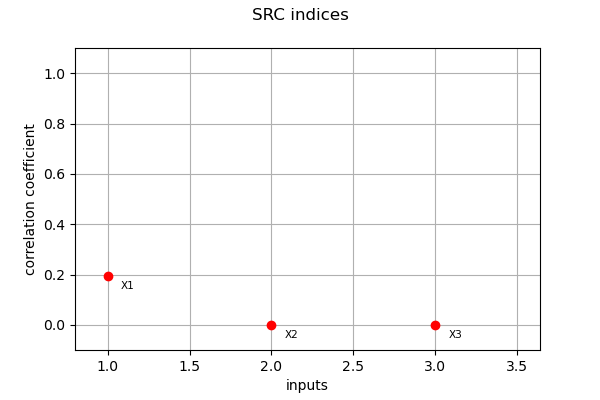

In [33]:
SRCindices = ot.CorrelationAnalysis_SRC(sampleX, sampleY)
input_names = g.getInputDescription()
title = "SRC indices"
ot.SobolIndicesAlgorithm.DrawCorrelationCoefficients(SRCindices, input_names, title)

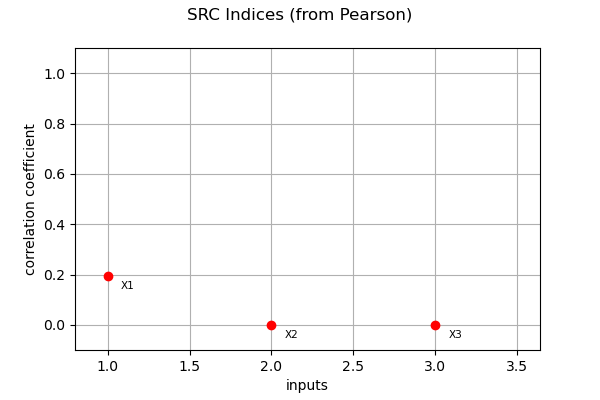

In [34]:
SRCindices = ot.Point(3)
SRCindices[0] = (
    ot.CorrelationAnalysis_PearsonCorrelation(sampleY, sampleX[:, 0])[0] ** 2
)
SRCindices[1] = (
    ot.CorrelationAnalysis_PearsonCorrelation(sampleY, sampleX[:, 1])[0] ** 2
)
SRCindices[2] = (
    ot.CorrelationAnalysis_PearsonCorrelation(sampleY, sampleX[:, 2])[0] ** 2
)
title = "SRC Indices (from Pearson)"
ot.SobolIndicesAlgorithm.DrawCorrelationCoefficients(SRCindices, input_names, title)

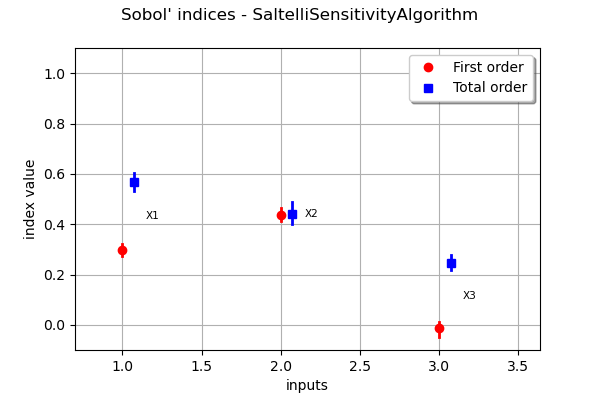

In [35]:
size = 10000
sie = ot.SobolIndicesExperiment(X, size, True)
inputDesign = sie.generate()
outputDesign = g(inputDesign)
sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)
graph = sensitivityAnalysis.draw()
graph

- On observe que la variable $X_1$, avec un indice de Sobol' total proche de 0.6, est la variable qui possède le plus d'impact par elle même ou par ses interactions. En effet, sont indice du premier ordre est proche de 0.3, ce qui implique que les interactions entre $X_1$ et les autres variables comptent pour approximativement 30% de la variance totale. 
- La variable $X_2$ possède un indice du premier ordre proche de l'indice total, ce qui implique qu'elle n'interagit pas avec les autres variables. Son indice total est approximativement égal à 0.4. 
- La variable $X_3$ possède un indice du premier ordre proche de zéro. Elle a un impact sur la variabilité de la sortie uniquement via ses interactions avec les autres variables. 

## Exercice 3 : variabilité de l'estimateur

On considère le cas de la déviation verticale de la poutre encastrée.

Avec une méthode Monte-Carlo et l'estimateur de Saltelli, on souhaite observer la variabilité de l'estimateur des indices du premier ordre. Pour cela, nous allons répéter l'estimation des indices du premier ordre $r$ fois, avec $r=100$. Dans chaque expérience, nous allons estimer les indices du premier ordre avec un plan d'expériences de taille $n$, avec $n=500$.

- Créer la variable `r=100`. 
- Créer la variable `sampleS` contenant un `Sample` de taille `r` et de dimension 4. Cette variable est destinée à contenir l'échantillon des estimations des indices du premier ordre.
- Créer la variable `n=500`.
- Créer une boucle `for` de 0 à `r-1`. Pour chaque élément `j` de la boucle, estimer les indices du premier ordre et stocker le résultat dans `sampleS[j,:]`.
- Dessiner l'histogramme empirique de l'indice de Sobol' du premier ordre pour la variable $E$
- Dessiner la loi gaussienne asymptotique issue de la méthode `getFirstOrderIndicesDistribution`. Est-ce que les deux distributions sont comparables ?

## Solution de l'exercice 3 : variabilité de l'estimateur


In [36]:
dist_E = ot.Beta(0.9, 2.2, 2.8e7, 4.8e7)
dist_E.setDescription(["E"])
F_para = ot.LogNormalMuSigma(3.0e4, 9.0e3, 15.0e3)  # in N
dist_F = ot.ParametrizedDistribution(F_para)
dist_F.setDescription(["F"])
dist_L = ot.Uniform(250.0, 260.0)  # in cm
dist_L.setDescription(["L"])
dist_I = ot.Beta(2.5, 1.5, 310.0, 450.0)  # in cm^4
dist_I.setDescription(["I"])

X = ot.ComposedDistribution([dist_E, dist_F, dist_L, dist_I])

In [37]:
g = ot.SymbolicFunction(["E", "F", "L", "I"], ["F* L^3 /  (3 * E * I)"])
g.setOutputDescription(["Y (cm)"])

In [38]:
r = 100
sampleS = ot.Sample(r, 4)
n = 500
for j in range(r):
    sie = ot.SobolIndicesExperiment(X, n, True)
    inputDesign = sie.generate()
    outputDesign = g(inputDesign)
    sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, n)
    sampleS[j, :] = sensitivityAnalysis.getFirstOrderIndices()

Pour dessiner la distribution asymptotique, nous créons la variable `mu` contenant la moyenne empirique de la i-ème colonne de `sampleS`. En effet, si l'on dessiner la distribution asymptotique sans modification de la moyenne, alors la gaussienne est centrée sur l'estimation associée à une seule expérience, et non pas sur le centre de l'histogramme. Cette situation est tout à fait normale. Toutefois, nous cherchons surtout à comparer la variance asymptotique et la variance empirique. C'est pour cette raison que, pouvoir comparer les deux distributions, nous décalons le centre de la gaussienne pour le mettre au centre de l'histogramme.

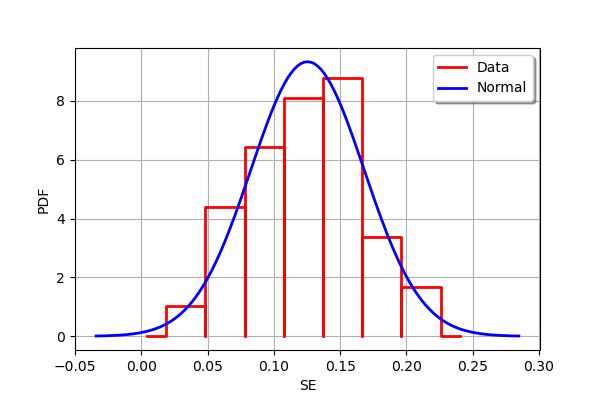

In [39]:
inputdesc = X.getDescription()
i = 0
histo = ot.HistogramFactory().build(sampleS[:, i]).drawPDF()
histo.setLegends(["Data"])
histo.setTitle("")
S = sensitivityAnalysis.getFirstOrderIndicesDistribution()
S1 = S.getMarginal(i)
mu = sampleS.computeMean()[i]
sigma = S1.getStandardDeviation()[i]
S1_shifted = ot.Normal(mu, sigma)
graphPDF = S1_shifted.drawPDF()
graphPDF.setColors(["blue"])
graphPDF.setLegends(["Normal"])
histo.setXTitle("S%s" % (inputdesc[i]))
histo.add(graphPDF)
histo

## Exercice 4 : estimation avec un algorithme

On considère le cas de la déviation verticale de la poutre encastrée. On souhaite mettre en oeuvre la méthode "pick-freeze" pour estimer les indices de sensibilité. 

- Utiliser une méthode Monte-Carlo, l'estimateur de Saltelli et une boucle `for` pour estimer les indices de Sobol' du premier ordre et les indices totaux.
Pour cela, on utilisera les deux fonctions `sumOfProduct` et `centeredG`suivantes.
- Utiliser l'estimateur de Martinez pour les indices du premier ordre et les indices totaux. Qu'observez-vous sur le plan du code ?
- Comparez les résultats produits par les deux méthodes : qu'observez-vous ?

In [40]:
def sumOfProduct(sampleA, sampleB):
    """Computes the dot product of two 1D-samples."""
    return np.dot(np.array(sampleA.asPoint()), np.array(sampleB.asPoint()))


def centeredG(sampleX):
    """Calcule la sortie de g, centrée par sa moyenne empirique."""
    sampleY = g(sampleX)
    EY = sampleY.computeMean()[0]
    centeredSampleY = sampleY - EY
    return centeredSampleY

## Solution de l'exercice 4 : estimation avec un algorithme

In [41]:
dist_E = ot.Beta(0.9, 2.2, 2.8e7, 4.8e7)
dist_E.setDescription(["E"])
F_para = ot.LogNormalMuSigma(3.0e4, 9.0e3, 15.0e3)  # in N
dist_F = ot.ParametrizedDistribution(F_para)
dist_F.setDescription(["F"])
dist_L = ot.Uniform(250.0, 260.0)  # in cm
dist_L.setDescription(["L"])
dist_I = ot.Beta(2.5, 1.5, 310.0, 450.0)  # in cm^4
dist_I.setDescription(["I"])

X = ot.ComposedDistribution([dist_E, dist_F, dist_L, dist_I])

In [42]:
g = ot.SymbolicFunction(["E", "F", "L", "I"], ["F* L^3 /  (3 * E * I)"])
g.setOutputDescription(["Y (cm)"])

Génère un premier plan d'expériences de taille `n`.

In [43]:
n = 10000
XA = X.getSample(n)
YA = g(XA)

Estime la moyenne et la variance de la sortie, puise centre l'échantillon des sorties YA.

In [44]:
EY = YA.computeMean()[0]
VY = YA.computeStandardDeviationPerComponent()[0]
YA = YA - EY  # Centre YA

Estime les indices du premier ordre et totaux.

In [45]:
dim = X.getDimension()
XB = X.getSample(n)
YB = centeredG(XB)
S = ot.Point(dim)
T = ot.Point(dim)
sumOfSquaresOfG = sumOfProduct(YA, YA)
for i in range(dim):
    XEi = ot.Sample(XA)
    XEi[:, i] = XB[:, i]
    YEi = centeredG(XEi)
    S[i] = sumOfProduct(YB, YEi) / sumOfSquaresOfG
    T[i] = 1.0 - sumOfProduct(YA, YEi) / sumOfSquaresOfG
print(S)
print(T)

[0.130374,0.751188,0.00132388,0.0453507]
[0.154288,0.804075,0.00848379,0.0630298]


Pour référence, voici les indices que nous avions obtenu avec `SaltelliSensitivityAlgorithm` :

- firstOrderIndices : [0.083937,0.840892,-0.0533628,0.00707767]
- totalOrderIndices : [0.189607,0.809751,0.00271451,0.0870107]

Avec l'algorithme incrémental :

- X0, S in [0.1118,0.1886], ST in [0.1151,0.1652]
- X1, S in [0.7675,1.0307], ST in [0.7860,0.8536]
- X2, S in [-0.0262,0.0429], ST in [0.0038,0.0175]
- X3, S in [0.0282,0.0993], ST in [0.0401,0.0765]

La cellule suivante utilise la méthode de Martinez pour l'estimation des indices de sensibilité. On observe que la méthode de Martinez centre les sorties de la fonction $g$, grâce à l'utilisation du coefficient de corrélation de Pearson.

In [46]:
dim = X.getDimension()
XB = X.getSample(n)
YB = centeredG(XB)
S = ot.Point(dim)
T = ot.Point(dim)
for i in range(dim):
    XEi = ot.Sample(XA)
    XEi[:, i] = XB[:, i]
    YEi = centeredG(XEi)
    S[i] = ot.CorrelationAnalysis_PearsonCorrelation(YB, YEi)[0]
    T[i] = 1.0 - ot.CorrelationAnalysis_PearsonCorrelation(YA, YEi)[0]
print(S)
print(T)

[0.139232,0.779374,0.0117574,0.060799]
[0.145797,0.796054,0.0108694,0.0605281]


## Exercice 5 : utilisation d'une séquence de Sobol' pour estimer les indices de Sobol'

Utiliser un plan d'expériences de type séquence à faible discrépance pour estimer les indices de sensibilité. Pour cela, on utilisera la séquence de Sobol'. 

Pour clarifier l'algorithme, on définira la fonction `martinezSobolIndices` qui utilisera l'estimateur de Martinez pour estimer les indices de Sobol'. Sa séquence d'appel devra être :
```
S, T = martinezSobolIndices(XA,XB)
```

Nous proposons d'utiliser cette fonction de telle sorte que `XA` e `XB` sont issus d'une séquence à faible discrépance de taille n en dimension $2p$. Puis, on découpera ce plan d'expériences en deux plans d'expériences de dimension $p$. La séquence de Sobol' peut être générée grâce aux classes `SobolSequence` et `LowDiscrepancyExperiment`. 


## Solution de l'exercice 5 : utilisation d'une séquence à faible discrépance

In [47]:
def martinezSobolIndices(XA, XB):
    YA = g(XA)
    EY = YA.computeMean()[0]
    VY = YA.computeStandardDeviationPerComponent()[0]
    YA = YA - EY  # Centre YA
    #
    dim = X.getDimension()
    YB = centeredG(XB)
    S = ot.Point(dim)
    T = ot.Point(dim)
    for i in range(dim):
        XEi = ot.Sample(XA)
        XEi[:, i] = XB[:, i]
        YEi = centeredG(XEi)
        S[i] = ot.CorrelationAnalysis_PearsonCorrelation(YB, YEi)[0]
        T[i] = 1.0 - ot.CorrelationAnalysis_PearsonCorrelation(YA, YEi)[0]
    return S, T

In [48]:
XA = X.getSample(n)
XB = X.getSample(n)
S, T = martinezSobolIndices(XA, XB)
print(S)
print(T)

[0.136102,0.785472,0.0229401,0.0654497]
[0.147828,0.791584,0.0109925,0.059673]


In [49]:
dim = X.getDimension()
distcoll = [X.getMarginal(i) for i in range(dim)]
distcoll

[class=Beta name=Beta dimension=1 alpha=0.9 beta=2.2 a=2.8e+07 b=4.8e+07,
 class=ParametrizedDistribution parameters=class=LogNormalMuSigma name=Unnamed mu=30000 sigma=9000 gamma=15000 distribution=class=LogNormal name=LogNormal dimension=1 muLog=9.46206 sigmaLog=0.554513 gamma=15000,
 class=Uniform name=Uniform dimension=1 a=250 b=260,
 class=Beta name=Beta dimension=1 alpha=2.5 beta=1.5 a=310 b=450]

In [50]:
twiceDistribution = ot.ComposedDistribution(distcoll * 2)
sequence = ot.SobolSequence(2 * dim)
experiment = ot.LowDiscrepancyExperiment(sequence, twiceDistribution, n)

In [51]:
fullDesign = experiment.generate()
# Split the A and B designs
A = fullDesign[:, 0:dim]
B = fullDesign[:, dim : 2 * dim]

In [52]:
S, T = martinezSobolIndices(XA, XB)
print(S)
print(T)

[0.136102,0.785472,0.0229401,0.0654497]
[0.147828,0.791584,0.0109925,0.059673]
